# using the XGBoost model to predict the number of unvalidated tickets 

Note : there is no way of verifying the accuracy of these given that it is in the future!

In [1]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Point

In [2]:
Pred_day = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe2/Pred_day.csv")

In [3]:
Pred_day.head()

,Stop_ID,Binned_time_x,Pre_2019,density,Visiting_score,Rel_Visiting_score,Validation_Count_mean,Number_entering_buses,time_sin,time_cos,...,NIMI_Ränilinna,NIMI_Supilinna,NIMI_Tammelinna,NIMI_Tähtvere,NIMI_Vaksali,NIMI_Variku,NIMI_Veeriku,NIMI_Ülejõe,Binned_day_0,Binned_day_1
0,7800528-1,2025-12-11 08:00:00,True,0,1,0.03125,1.833333,4,8.660254e-01,-0.500000,...,False,False,False,False,False,False,False,False,True,False
1,7800528-1,2025-12-11 10:00:00,True,0,1,0.03125,1.400000,4,5.000000e-01,-0.866025,...,False,False,False,False,False,False,False,False,True,False
2,7800528-1,2025-12-11 12:00:00,True,0,1,0.03125,1.000000,4,1.224647e-16,-1.000000,...,False,False,False,False,False,False,False,False,True,False
3,7800528-1,2025-12-11 14:00:00,True,0,1,0.03125,1.000000,4,-5.000000e-01,-0.866025,...,False,False,False,False,False,False,False,False,True,False
4,7800528-1,2025-12-11 16:00:00,True,0,1,0.03125,1.750000,4,-8.660254e-01,-0.500000,...,False,False,False,False,False,False,False,False,True,False


### Loading and using the XGboost model

In [4]:

# Load model
loaded_model = XGBClassifier()
loaded_model.load_model("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/4_Hyperparam_tuning_XGBoost/Pipe1/xgb_model.json")

# Drop target
X_pred = Pred_day.drop(columns=["Number_entering_buses", "Stop_ID", "Binned_time_x"])

# Columns to scale
cols_to_scale = ["density", "Visiting_score", "Rel_Visiting_score", "Validation_Count_mean"]

# Load or define scaler fitted on training data
# scaler = joblib.load("scaler.save")  # if you saved it
scaler = StandardScaler()
X_pred[cols_to_scale] = scaler.fit_transform(X_pred[cols_to_scale])  # only if you don't have saved scaler

# Ensure same column order as model expects
X_pred = X_pred[loaded_model.get_booster().feature_names]

# Predict probabilities
y_prob = loaded_model.predict_proba(X_pred)[:, 1]


### Applying threshold

In [5]:
# best_thresh was obtained from my ROC analysis
best_thresh = 0.128

# Apply threshold to probabilities
y_pred = (y_prob >= best_thresh).astype(int)

# y_pred now contains 0s and 1s
unique, counts = np.unique(y_pred, return_counts = True)
print(unique, counts)


[0 1] [2357   67]


### Calcualting bus stop score

In [6]:
# Rememeber - the mean threshold was 1 - meaning - on average, each bus has 1 fare evadee 

Prediction = Pred_day[["Number_entering_buses", "Stop_ID", "Binned_time_x"]]
Prediction = Prediction.assign(y_pred=y_pred, y_prob=y_prob)


# y_prob → weights the expected number of fare evadees by the predicted probability.
# y_pred → masks predictions where the model classified it as 0 (no fare evadee)
Prediction["Score"] = Prediction["Number_entering_buses"] * y_prob


In [7]:
Prediction.head()

,Number_entering_buses,Stop_ID,Binned_time_x,y_pred,y_prob,Score
0,4,7800528-1,2025-12-11 08:00:00,0,0.123163,0.492650
1,4,7800528-1,2025-12-11 10:00:00,0,0.122854,0.491414
2,4,7800528-1,2025-12-11 12:00:00,0,0.123046,0.492183
3,4,7800528-1,2025-12-11 14:00:00,0,0.125422,0.501689
4,4,7800528-1,2025-12-11 16:00:00,0,0.125422,0.501689


In [8]:
# Merging with stop locations 
Post_2019_mapped_stops = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe7/Post_2019_mapped_stops.csv")


Merged = Prediction.merge(Post_2019_mapped_stops, left_on = "Stop_ID", right_on = "Stop_ID")
Merged["Binned_time_x"] = pd.to_datetime(Merged["Binned_time_x"])
Merged["Time"] = Merged["Binned_time_x"].dt.time
Merged.head()
Merged["NIMI"].unique()

array(['Ihaste', 'Raadi-Kruusamäe', 'Ropka', 'Karlova', 'Annelinna',
       'Veeriku', 'Maarjamõisa', 'Ülejõe', 'Kesklinna', 'Tähtvere',
       'Ränilinna', 'Supilinna', 'Tammelinna', 'Ropka tööstuse',
       'Vaksali', 'Jaamamõisa', 'Variku', 'Kvissentali'], dtype=object)

EPSG:3301


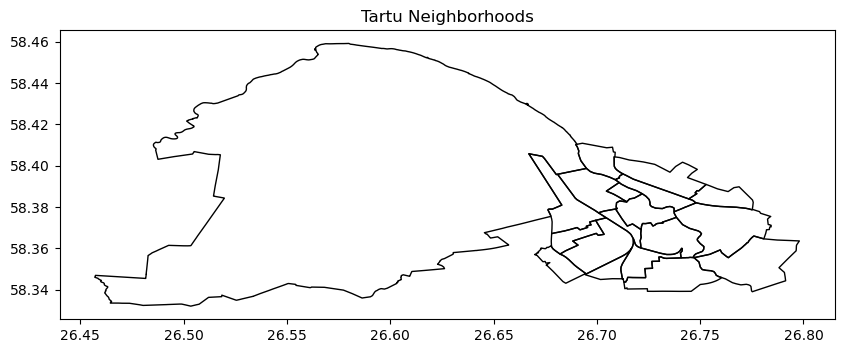

In [9]:
## Loading in the districts 

neighborhoods_gdf = gpd.read_file("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/Neighbourhoods/Tartu_linnaosad_wgs84.geojson")
neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:3301")

neighborhoods_gdf.plot(edgecolor='black', facecolor='none', figsize=(10,10))
print(neighborhoods_gdf.crs)
plt.title("Tartu Neighborhoods")
plt.show()

### Mapping the scores onto the tartu map

In [12]:
from matplotlib.colors import LinearSegmentedColormap


In [27]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.colors as mcolors

def Mapping_scores(df, neighborhoods_gdf):
    """
    Plots bus stop scores on Tartu neighborhoods.
    - Zero scores greyed out
    - Positive scores colored and sized by magnitude
    - One plot per binned time
    - Uses consistent size and color scaling across all times
    """
    # Convert stops to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=[Point(xy) for xy in zip(df['stop_lon'], df['stop_lat'])],
        crs="EPSG:3301"
    )
    gdf = gdf.to_crs(neighborhoods_gdf.crs)

    # Assign stops to neighborhoods
    Mapping_stops = gpd.sjoin(
        gdf,
        neighborhoods_gdf[['NIMI','geometry']],
        how='left',
        predicate='within'
    )

    missing = Mapping_stops['NIMI_right'].isna()
    if missing.any():
        nearest_idx = gdf.loc[missing].geometry.apply(
            lambda geom: neighborhoods_gdf.geometry.distance(geom).idxmin()
        )
        Mapping_stops.loc[missing, 'NIMI'] = neighborhoods_gdf.loc[nearest_idx, 'NIMI'].values

    # Optionally remove unwanted neighborhood
    neighborhoods_gdf = neighborhoods_gdf[neighborhoods_gdf['NIMI'] != 'Endine Tähtvere vald']

    # Global max score for consistent scaling
    global_max_score = Mapping_stops['Score'].max()
    min_marker_size = 20
    max_marker_size = 200

    # Define normalization for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=global_max_score)
    cmap = LinearSegmentedColormap.from_list(
        "dodgerblue_gradient",
        ["white", "Dodgerblue"]   # or ["lightblue", "dodgerblue"] for stronger contrast
        )


    for index, t in enumerate(Mapping_stops["Binned_time_x"].sort_values().unique()):
        fig, ax = plt.subplots(figsize=(10,10))
        
        # Plot neighborhoods in background
        neighborhoods_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
        
        subset = Mapping_stops[Mapping_stops["Binned_time_x"] == t]

        # Plot zero scores
        zeros = subset[subset["Score"] == 0]
        if not zeros.empty:
            zeros.plot(ax=ax, color='lightgrey', markersize=min_marker_size)

        # Plot positive scores with consistent size and color scaling
        positives = subset[subset["Score"] > 0]
        if not positives.empty:
            sizes = min_marker_size + (positives["Score"] / global_max_score) * (max_marker_size - min_marker_size)
            positives.plot(
                ax=ax,
                color=[cmap(norm(s)) for s in positives["Score"]],
                markersize=sizes,
            )

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label('Score', fontsize=12)

        # Title and clean axes
        plt.title(f"Bus Stop Scores at {t}", fontsize=14)
        plt.axis('off')
        plt.savefig(f"c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe3/Mapped_scores{index}.svg",format='svg', bbox_inches='tight')
        plt.show()

    return Mapping_stops

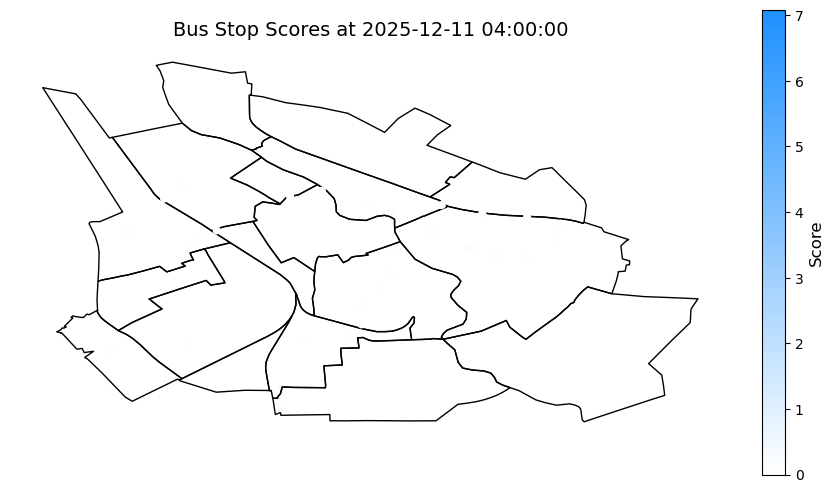

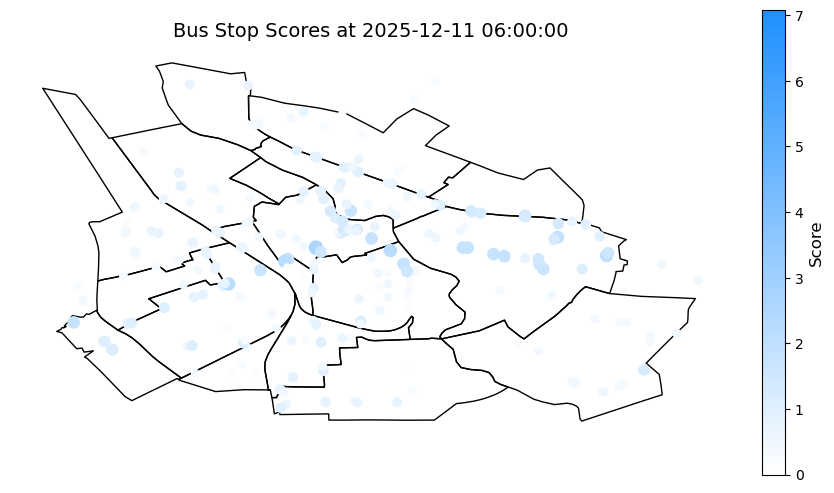

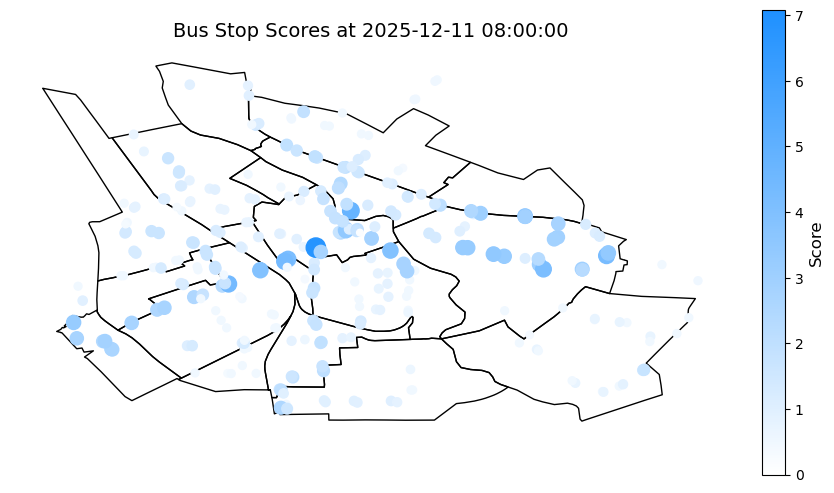

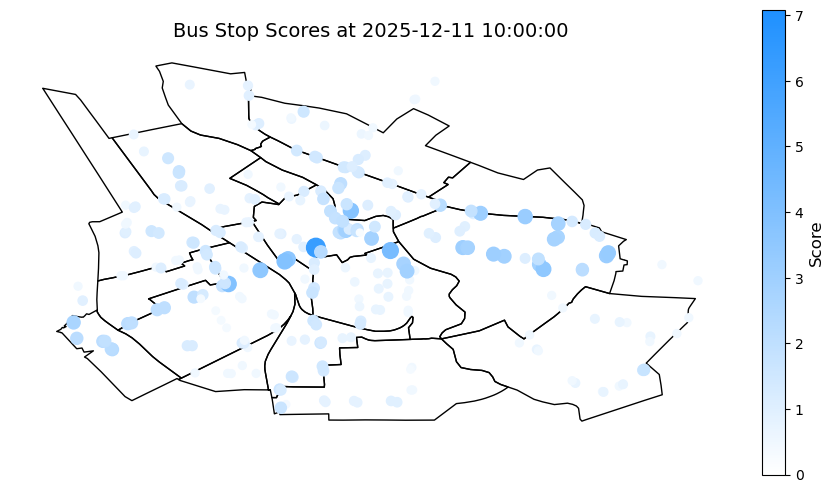

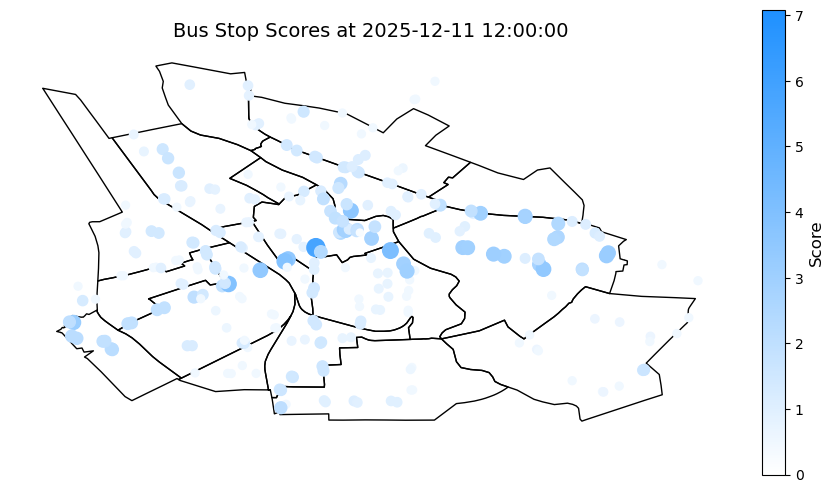

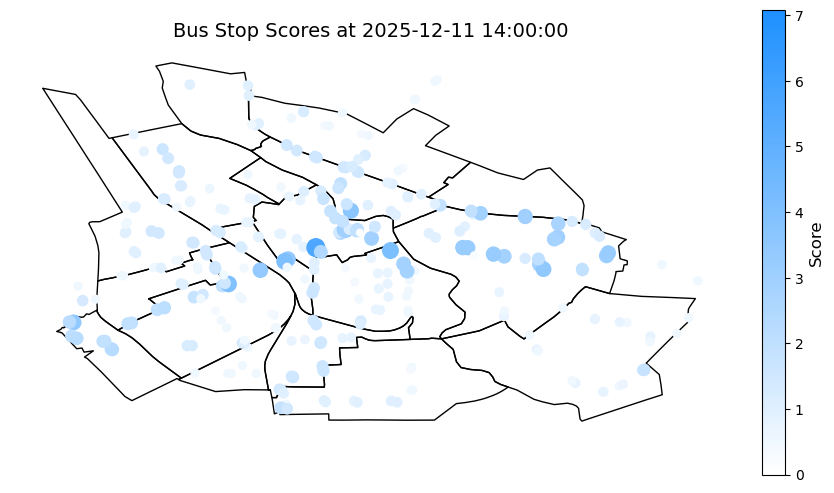

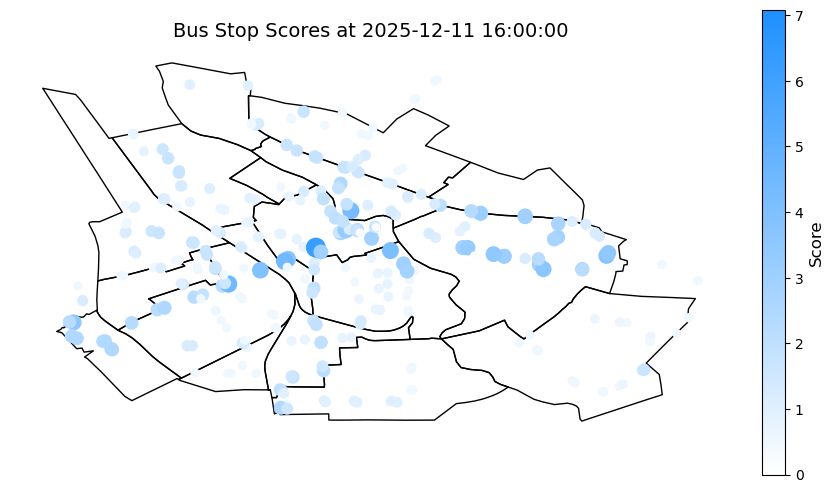

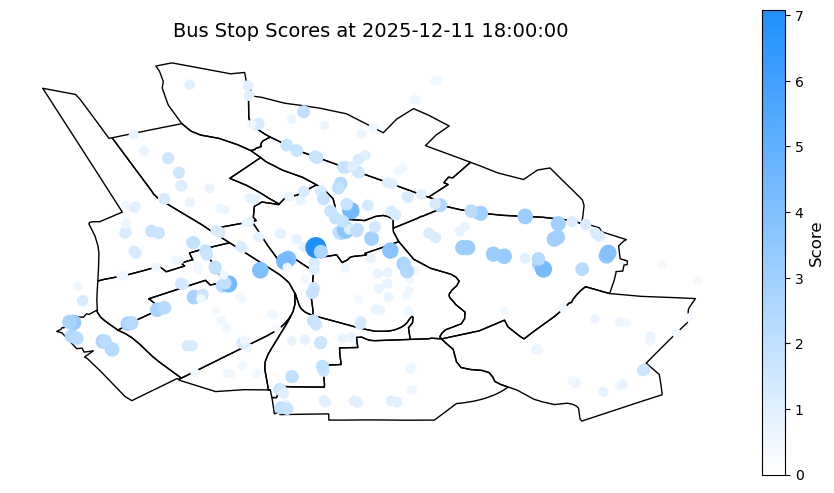

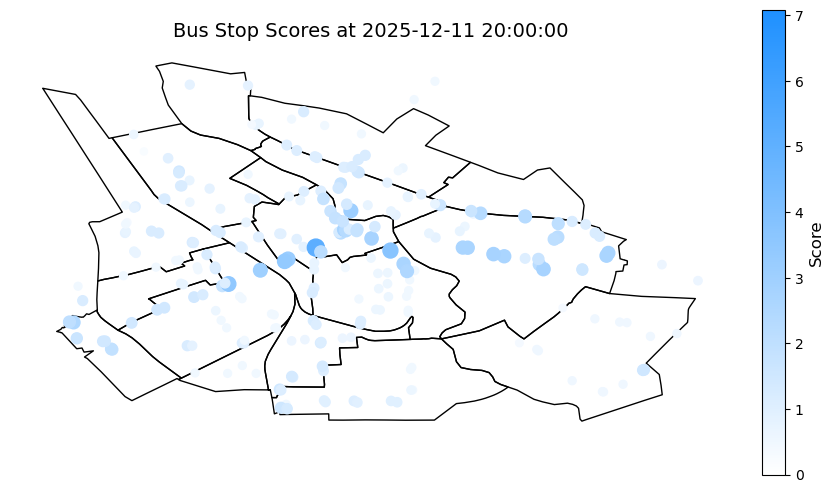

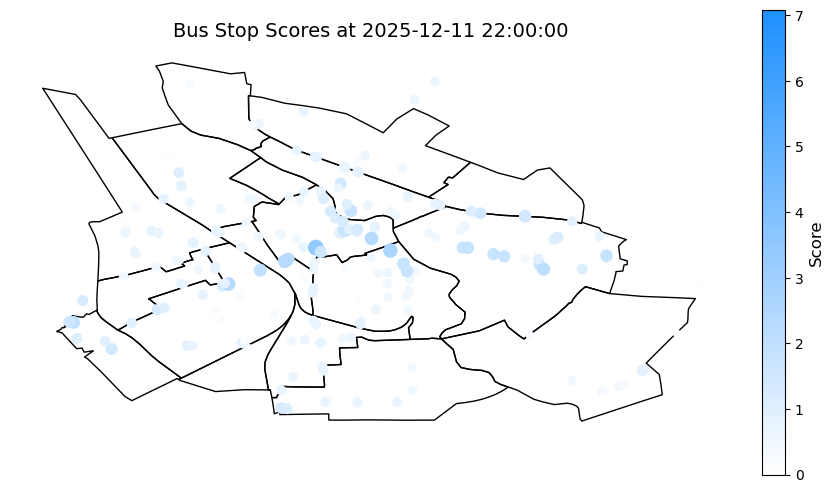

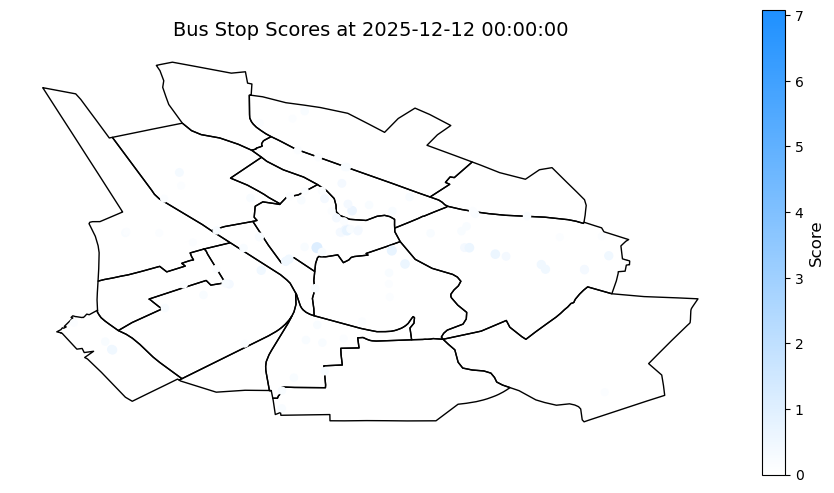

In [28]:
Mapping_scores = Mapping_scores(Merged, neighborhoods_gdf)

## Extracting feature importance

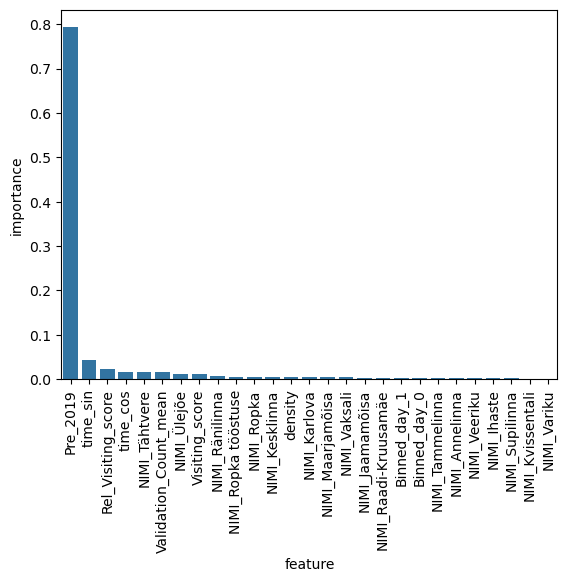

In [4]:
import seaborn as sns

X = ['Pre_2019', 'Validation_Count_mean', 'Visiting_score',
       'Rel_Visiting_score', 'density', 'time_sin', 'time_cos',
       'NIMI_Annelinna', 'NIMI_Ihaste', 'NIMI_Jaamamõisa', 'NIMI_Karlova',
       'NIMI_Kesklinna', 'NIMI_Kvissentali', 'NIMI_Maarjamõisa',
       'NIMI_Raadi-Kruusamäe', 'NIMI_Ropka', 'NIMI_Ropka tööstuse',
       'NIMI_Ränilinna', 'NIMI_Supilinna', 'NIMI_Tammelinna', 'NIMI_Tähtvere',
       'NIMI_Vaksali', 'NIMI_Variku', 'NIMI_Veeriku', 'NIMI_Ülejõe',
       'Binned_day_0', 'Binned_day_1']

# Load model

model = XGBClassifier()
model.load_model("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/4_Hyperparam_tuning_XGBoost/Pipe1/xgb_model.json")

# Reattach feature names
model.get_booster().feature_names = X

import pandas as pd
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": X,
    "importance": importances
}).sort_values("importance", ascending=False)


sns.barplot(data = feature_importance_df, x = "feature", y = "importance")
plt.xticks(rotation = 90)
plt.show()

## Exporting the mapped scores

In [24]:
Mapping_scores.to_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe3/Mapping_scores.csv", index = False)